### Data Import

In [2]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
mpl.rcParams["axes.unicode_minus"] = False
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import glob
import numpy as np
import pandas as pd
import os, sys, math, copy
import scipy.io as sio

from collections import OrderedDict
import flwr as fl
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm

In [2]:
def path2df(path):
    all_files = glob.glob(path + "\CNC Virtual Data set _v2\*.csv")
    exp_result = pd.read_csv(path + "\\train.csv")
    df_lst = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col = None, header = 0)
        df_lst.append(df)
    
    return exp_result, df_lst

path_aluminum = r'C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\aluminum\CNC 비식별화 원본데이터_1209'
path_wax = r'C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\wax'

res_aluminum, lst_aluminum = path2df(path_aluminum)
res_wax, lst_wax = path2df(path_wax)

In [3]:
res_aluminum.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,aluminum,6,4.0,unworn,yes,yes
1,2,aluminum,20,4.0,unworn,yes,yes
2,3,aluminum,6,3.0,unworn,yes,yes
3,4,aluminum,6,2.5,unworn,no,NaN
4,5,aluminum,20,3.0,unworn,no,NaN


In [4]:
lst_aluminum[0].head()

,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_CurrentFeedback,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process
0,202,4.0,4.00,202,4.0,4.000000,0.18,0.0207,329,2.77,...,0.524,2.740000e-19,329,0.0,6.960000e-07,16,1,0,50,Starting
1,202,-6.8,-346.00,202,-9.6,-354.000000,-10.90,0.1860,328,23.30,...,-0.288,2.740000e-19,328,0.0,-5.270000e-07,16,1,4,50,Prep
2,200,-13.8,-2.25,200,-13.9,3.999905,-8.59,0.1400,328,30.60,...,0.524,2.740000e-19,328,0.0,9.100000e-07,16,1,7,50,Prep
3,198,-14.0,4.00,198,-13.9,3.999905,-6.11,0.1300,327,30.30,...,-0.180,2.740000e-19,328,0.0,1.070000e-06,16,1,7,50,Prep
4,197,-13.9,-14.80,196,-13.9,4.000095,-5.70,0.1140,328,30.50,...,0.226,2.740000e-19,328,0.0,1.960000e-06,16,1,7,50,Prep


### EDA
- 시간에 따른 공정 상태 확인 (시간은 나타내어져 있지 않지만, row index가 커질 수록 item이 완성에 가까워지므로 '시간에 따른'으로 표현)
- 공정 완료 직전에 어떤 상태였는지 확인 (특이점이 있을 수도 있다고 생각함)

In [5]:
def len2size(length):
    min = 9999
    min_row = 0
    min_col = 0
    for i in range(1, length+1):
        if length%i == 0:
            row, col = i, length//i
            if min > row + col:
                min = row + col
                min_row, min_col = row, col
    return min_row, min_col

def draw_process(df_lst, exp_result):

    label = ['Prep', 'Layer 1 Up', 'Layer 1 Down', 
         'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down',
         'Repositioning', 'Starting', 'End']

    mapping = {label[i]: i for i in range(len(label))}
    mapping['end'] = 9

    row, col = len2size(len(exp_result))
    f, ax = plt.subplots(row, col, figsize = (col*5, row*3))

    for i in range(len(df_lst)):
        transform = df_lst[i]['Machining_Process'].map(mapping)
        if exp_result['machining_finalized'][i] == 'yes':
            ax[i//col, i%col].plot(transform, color = 'crimson')
        else: ax[i//col, i%col].plot(transform)
        
        ax[i//col, i%col].set_title(f"Experiment {i+1}'s visual inspection: {exp_result['passed_visual_inspection'][i]}")
    plt.subplots_adjust(hspace = 0.5)
    plt.show()

if machining finalized: plot's color is red


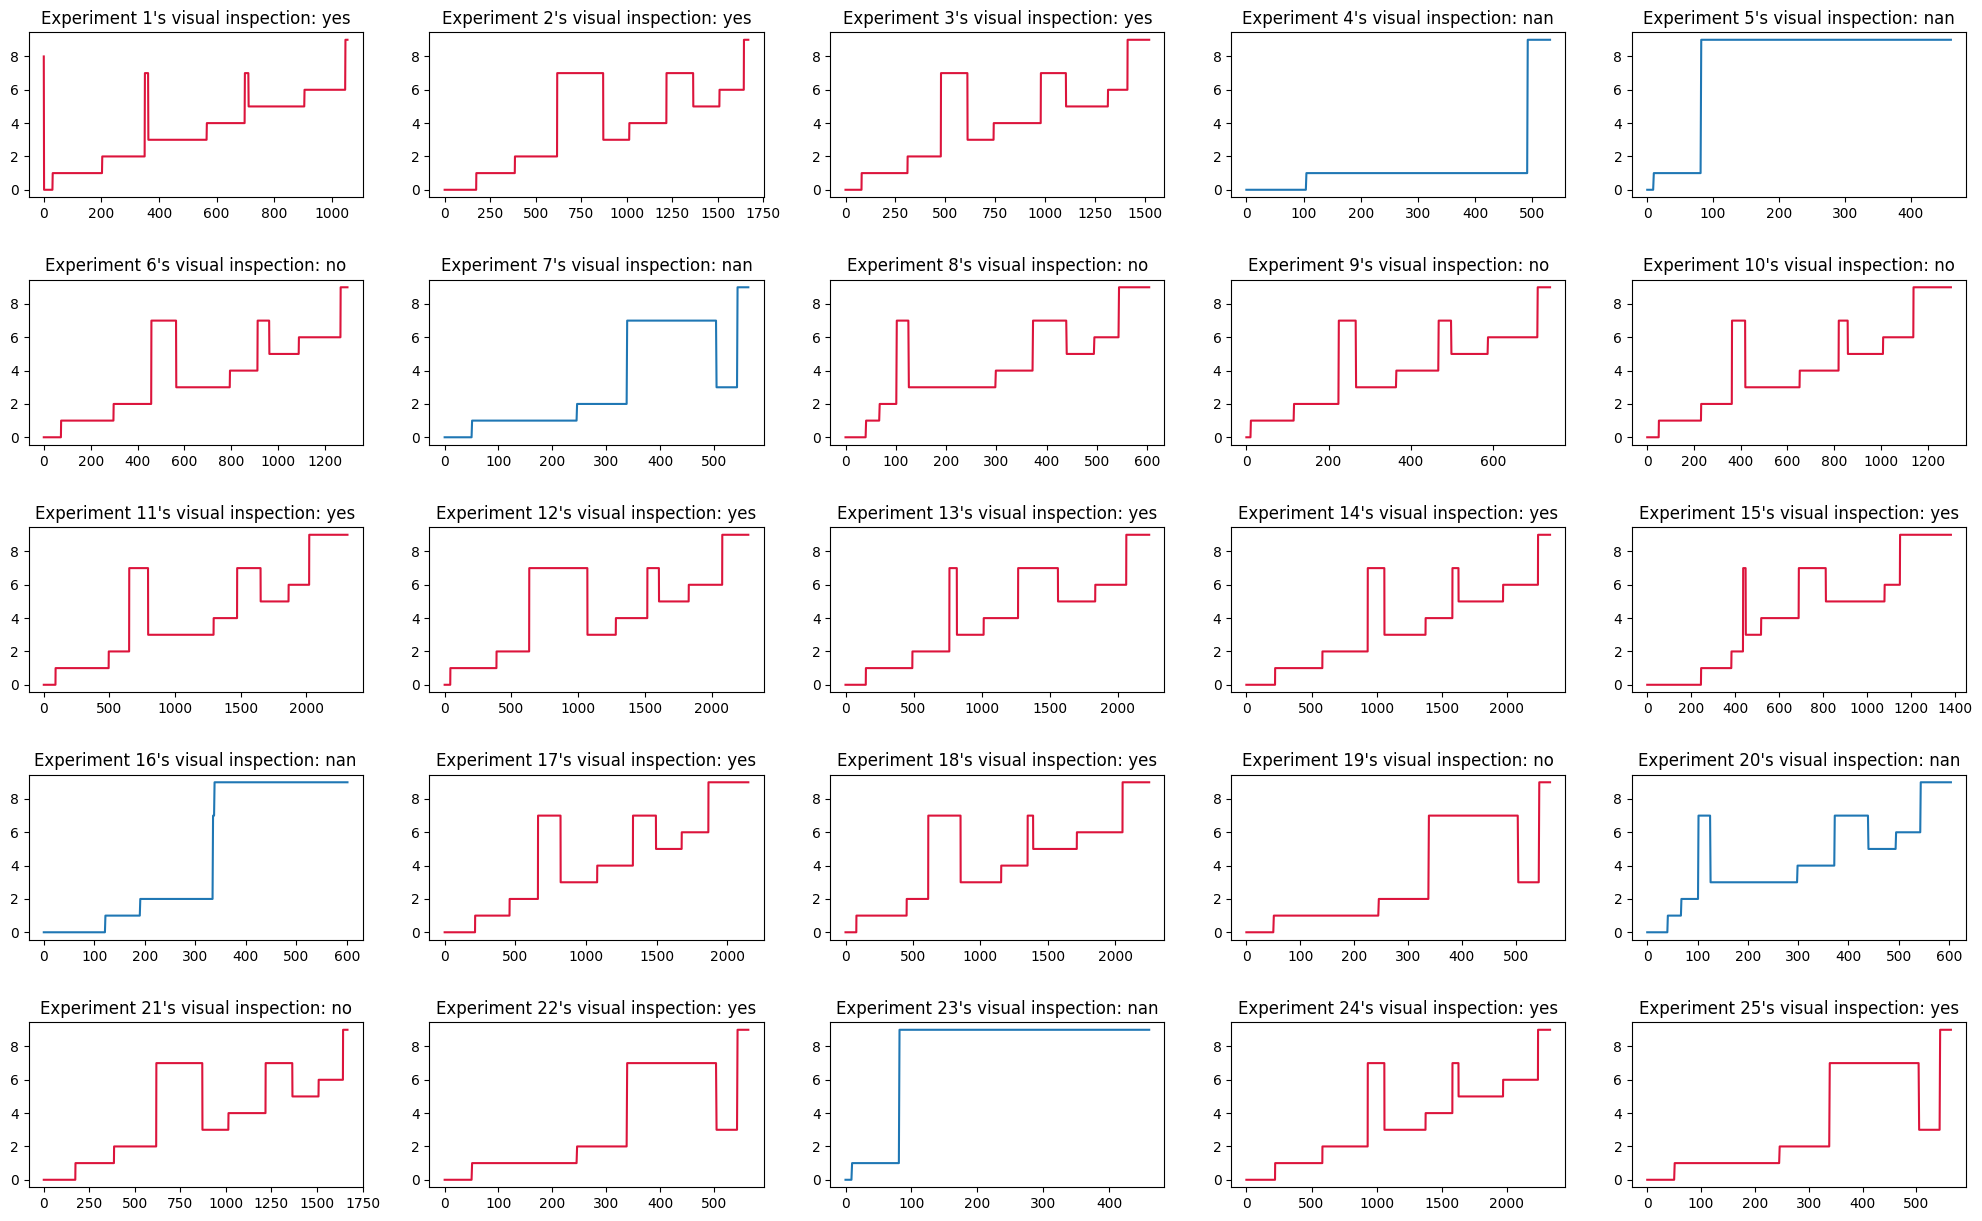

In [6]:
print("if machining finalized: plot's color is red")
draw_process(lst_aluminum, res_aluminum)

if machining finalized: plot's color is red


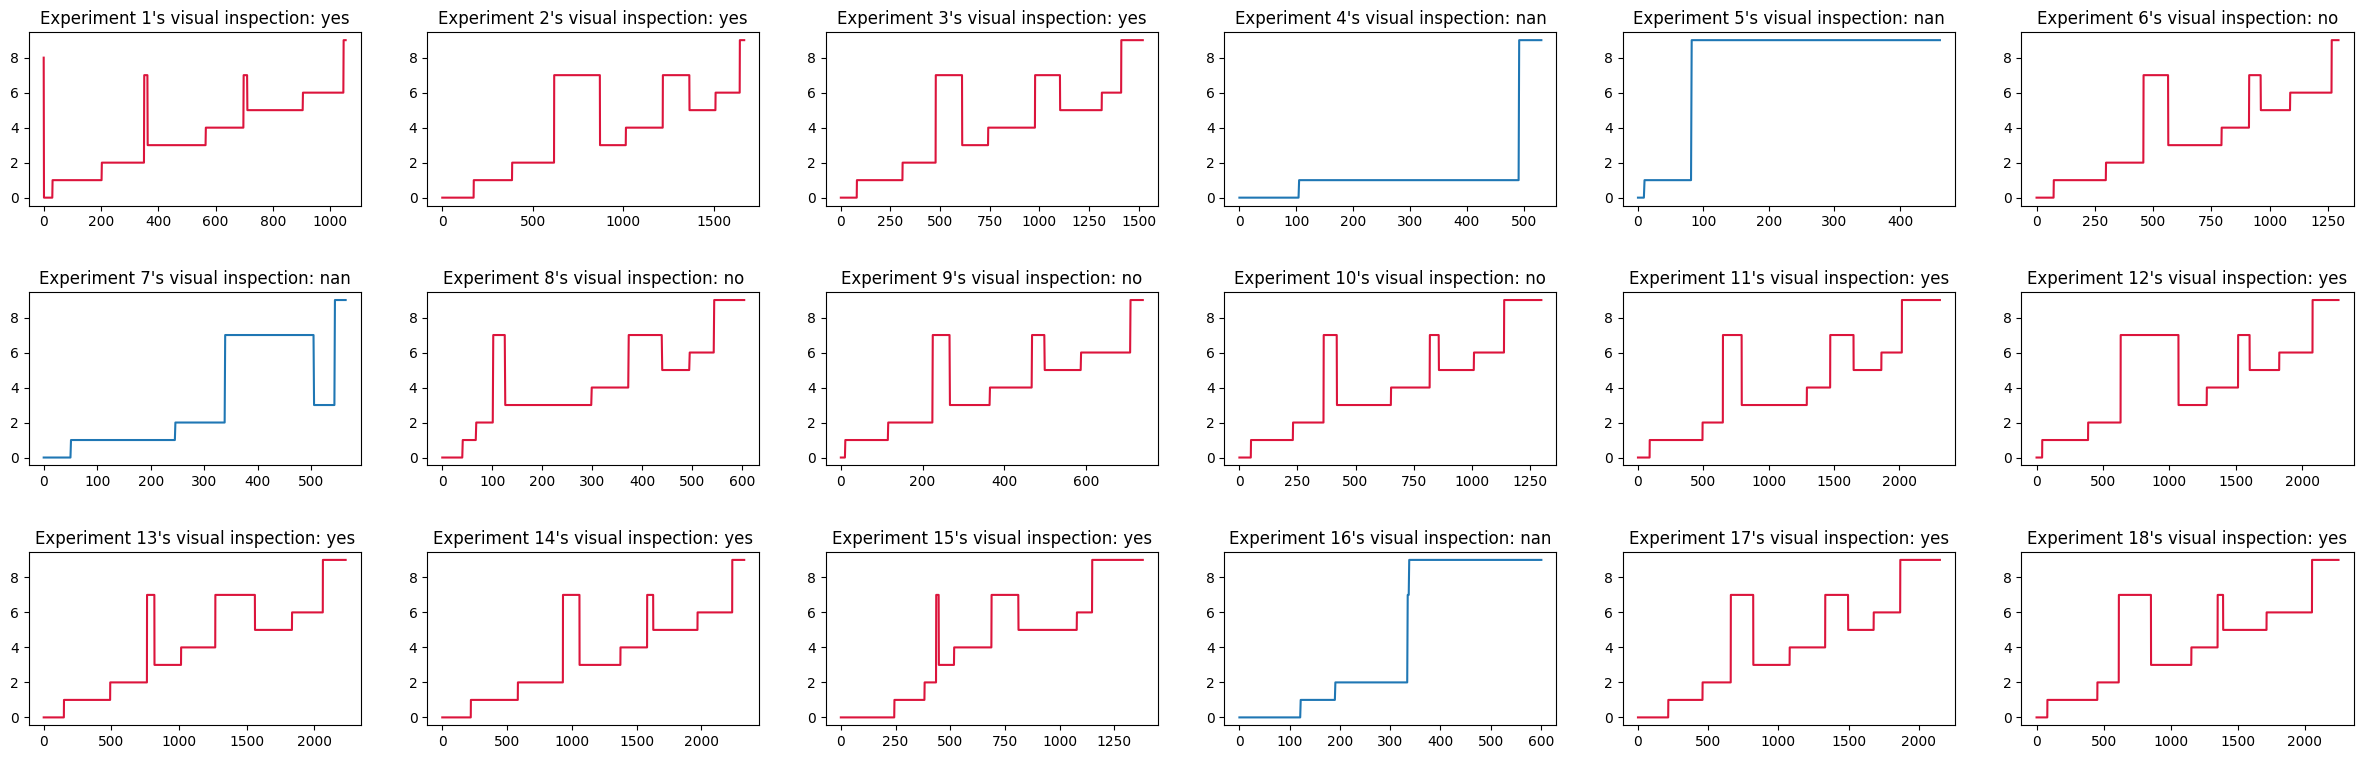

In [7]:
print("if machining finalized: plot's color is red")
draw_process(lst_wax, res_wax)

In [8]:
def state_before_end(exp_result, df_lst):
    label = ['Prep', 'Layer 1 Up', 'Layer 1 Down', 
            'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down',
            'Repositioning', 'Starting', 'End']

    mapping = {label[i]: i for i in range(len(label))}
    mapping['end'] = 9
    total_end = []

    for i in range(len(df_lst)):
        transform = df_lst[i]['Machining_Process'].map(mapping)
        before_end = [e for e in transform if e < 9]
        total_end.append(before_end[-1])

    inverse_mapping = {v: k for k, v in mapping.items()}
    exp_result['before_end'] = pd.Series(total_end).map(inverse_mapping)

    print('state before end of each experiment')
    return exp_result.loc[:, ['No','machining_finalized', 'passed_visual_inspection', 'before_end']]

In [9]:
state_before_end(res_aluminum, lst_aluminum)

state before end of each experiment


,No,machining_finalized,passed_visual_inspection,before_end
0,1,yes,yes,Layer 3 Down
1,2,yes,yes,Layer 3 Down
2,3,yes,yes,Layer 3 Down
3,4,no,NaN,Layer 1 Up
4,5,no,NaN,Layer 1 Up
5,6,yes,no,Layer 3 Down
6,7,no,NaN,Layer 2 Up
7,8,yes,no,Layer 3 Down
8,9,yes,no,Layer 3 Down
9,10,yes,no,Layer 3 Down


In [10]:
state_before_end(res_wax, lst_wax)

state before end of each experiment


,No,machining_finalized,passed_visual_inspection,before_end
0,1,yes,yes,Layer 3 Down
1,2,yes,yes,Layer 3 Down
2,3,yes,yes,Layer 3 Down
3,4,no,NaN,Layer 1 Up
4,5,no,NaN,Layer 1 Up
5,6,yes,no,Layer 3 Down
6,7,no,NaN,Layer 2 Up
7,8,yes,no,Layer 3 Down
8,9,yes,no,Layer 3 Down
9,10,yes,no,Layer 3 Down


- aluminum Experiment 25와 같이 Layer을 모두 거치지 않더라도 공정 검사, 육안 검사 모두 통과할 수 있다.
- aluminum Experiment 20과 같이 Layer3을 모두 거치더라도 공정 검사에서 떨어질 수 있다. (하지만 wax의 경우, Layer3에서 끝나지 않는다면 불량으로 판정됐다.)
- exp result(res_aluminum, res_wax)를 통해 label을 생성한다.
- Model의 Input: df_lst[i], Model의 Output: Experiment의 공정, 육안 검사 통과 여부
- 즉, item 생산 과정 일부를 보고 item(experiment)의 양, 불량을 예측한다.

### EDA: label(target feature)

- 공정 검사(machining finalized), 육안 검사(passed visual inspection) 통과 여부로 label 생성
- 모두 통과 : 0
- 공정 검사만 통과 or 공정 검사 탈락: 1

In [11]:
def exp_inspection(machine, visual):
    # all pass
    if machine == 'yes' and visual == 'yes':
        return 0
    # half pass
    if machine == 'yes' and visual == 'no':
        return 1
    # fail
    if machine == 'no':
        return 1
    
res_aluminum['total_inspection'] = res_aluminum.apply(
    lambda x: exp_inspection(x.machining_finalized, x.passed_visual_inspection), 
    axis = 1)

res_wax['total_inspection'] = res_wax.apply(
    lambda x: exp_inspection(x.machining_finalized, x.passed_visual_inspection), 
    axis = 1)

In [12]:
for i in range(len(lst_aluminum)):
    lst_aluminum[i]['target'] = res_aluminum['total_inspection'][i]
    lst_aluminum[i]['material'] = 'aluminum'

for i in range(len(lst_wax)):
    lst_wax[i]['target'] = res_wax['total_inspection'][i]
    lst_wax[i]['material'] = 'wax'

lst_aluminum[0].iloc[:, -2:]

,target,material
0,0,aluminum
1,0,aluminum
2,0,aluminum
3,0,aluminum
4,0,aluminum
...,...,...
1050,0,aluminum
1051,0,aluminum
1052,0,aluminum
1053,0,aluminum


In [13]:
def concat_by_material(df_lst):
    concat_df = pd.concat(df_lst, axis = 0).reset_index(drop = True)
    return concat_df

df_aluminum = concat_by_material(lst_aluminum)
df_wax = concat_by_material(lst_wax)

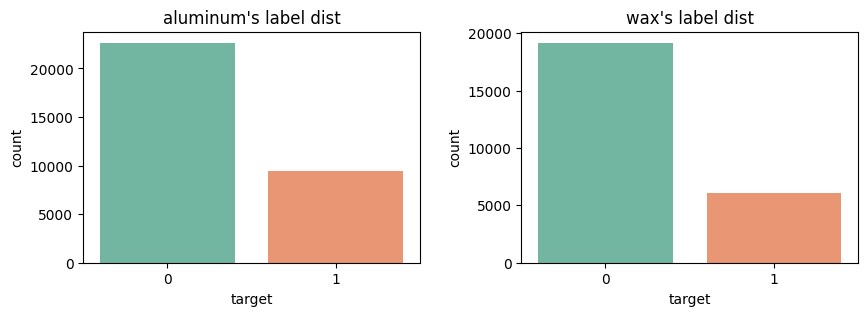

In [14]:
f, ax = plt.subplots(1, 2, figsize = (10, 3))

sns.countplot(data = df_aluminum, x = 'target', ax = ax[0], palette ='Set2')
ax[0].set_title("aluminum's label dist")

sns.countplot(data = df_wax, x = 'target', ax = ax[1], palette = 'Set2')
ax[1].set_title("wax's label dist")

plt.subplots_adjust(wspace = 0.3)
plt.show()

### Data Preprocessing

In [15]:
label = ['Prep', 'Layer 1 Up', 'Layer 1 Down', 
            'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down',
            'Repositioning', 'Starting', 'End']

mapping = {label[i]: i for i in range(len(label))}
mapping['end'] = 9

process_aluminum = df_aluminum['Machining_Process'].map(mapping)
df_aluminum['process'] = process_aluminum

process_wax = df_wax['Machining_Process'].map(mapping)
df_wax['process'] = process_wax

In [16]:
def preprocess(df):
    columns = df.columns[:47].tolist() + ['process', 'target']
    ndf = df.loc[:, ~df.columns.isin(['cid', 'Machining_Process'])]
    ndf = ndf.loc[:, columns]
    scaler = MinMaxScaler()
    scaler.fit(ndf)
    ndf = scaler.transform(ndf)
    ndf = pd.DataFrame(ndf, columns = columns)
    ndf['cid'] = df['cid']
    ndf['target'] = ndf['target'].astype(int)
    return ndf.loc[:, ['cid']+columns]

In [17]:
# preprocess pipeline (all-in-one)
def path2df(path):
    all_files = glob.glob(path + "\CNC Virtual Data set _v2\*.csv")
    exp_result = pd.read_csv(path + "\\train.csv")
    df_lst = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col = None, header = 0)
        df_lst.append(df)
    
    return exp_result, df_lst

def exp_inspection(machine, visual):
    # all pass
    if machine == 'yes' and visual == 'yes':
        return 0
    # half pass
    if machine == 'yes' and visual == 'no':
        return 1
    # fail
    if machine == 'no':
        return 1

def concat_by_material(df_lst):
    concat_df = pd.concat(df_lst, axis = 0).reset_index(drop = True)
    return concat_df

def preprocess(df):
    columns = df.columns[:47].tolist() + ['process', 'target']
    ndf = df.loc[:, ~df.columns.isin(['cid', 'Machining_Process'])]
    ndf = ndf.loc[:, columns]
    scaler = MinMaxScaler()
    scaler.fit(ndf)
    ndf = scaler.transform(ndf)
    ndf = pd.DataFrame(ndf, columns = columns)
    ndf['cid'] = df['cid']
    ndf['target'] = ndf['target'].astype(int)
    return ndf.loc[:, ['cid']+columns]

def data_preprocessing():
    path_aluminum = r'C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\aluminum\CNC 비식별화 원본데이터_1209'
    path_wax = r'C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\wax'

    res_aluminum, lst_aluminum = path2df(path_aluminum)
    res_wax, lst_wax = path2df(path_wax)

    # generate target variable
    res_aluminum['total_inspection'] = res_aluminum.apply(
        lambda x: exp_inspection(x.machining_finalized, x.passed_visual_inspection), 
        axis = 1)

    res_wax['total_inspection'] = res_wax.apply(
        lambda x: exp_inspection(x.machining_finalized, x.passed_visual_inspection), 
        axis = 1)
    
    for i in range(len(lst_aluminum)):
        lst_aluminum[i]['target'] = res_aluminum['total_inspection'][i]
        lst_aluminum[i]['cid'] = 0

    for i in range(len(lst_wax)):
        lst_wax[i]['target'] = res_wax['total_inspection'][i]
        lst_wax[i]['cid'] = 1
    
    # concatenate experiment dataset by material
    df_aluminum = concat_by_material(lst_aluminum)
    df_wax = concat_by_material(lst_wax)

    # Machining Process -> nuermic
    label = ['Prep', 'Layer 1 Up', 'Layer 1 Down', 
            'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down',
            'Repositioning', 'Starting', 'End']

    mapping = {label[i]: i for i in range(len(label))}
    mapping['end'] = 9

    process_aluminum = df_aluminum['Machining_Process'].map(mapping)
    df_aluminum['process'] = process_aluminum

    process_wax = df_wax['Machining_Process'].map(mapping)
    df_wax['process'] = process_wax

    # Data normalization
    ndf_aluminum = preprocess(df_aluminum)
    ndf_wax = preprocess(df_wax)

    # concatenate aluminum and wax dataset
    ndf_wax.columns = ndf_aluminum.columns
    ndf = pd.concat([ndf_aluminum, ndf_wax], axis = 0).reset_index(drop = True)

    return ndf

In [18]:
ndf = data_preprocessing()
ndf

,cid,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,...,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,process,target
0,0,0.983051,0.293388,0.470394,0.983051,0.291667,0.500000,0.466931,0.054474,0.818182,...,8.670886e-20,0.928571,0.000000,0.005176,0.5,0.25,0.000000,1.0,0.888889,0
1,0,0.983051,0.144628,0.341670,0.983051,0.102778,0.321179,0.247525,0.489474,0.727273,...,8.670886e-20,0.904762,0.000000,0.005174,0.5,0.25,0.029630,1.0,0.000000,0
2,0,0.949153,0.048209,0.468095,0.949153,0.043056,0.500000,0.293267,0.368421,0.727273,...,8.670886e-20,0.904762,0.000000,0.005177,0.5,0.25,0.051852,1.0,0.000000,0
3,0,0.915254,0.045455,0.470394,0.915254,0.043056,0.500000,0.342376,0.342105,0.636364,...,8.670886e-20,0.904762,0.000000,0.005177,0.5,0.25,0.051852,1.0,0.000000,0
4,0,0.898305,0.046832,0.463479,0.881356,0.043056,0.500000,0.350495,0.300000,0.727273,...,8.670886e-20,0.904762,0.000000,0.005179,0.5,0.25,0.051852,1.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57329,1,0.052632,0.254571,0.507353,0.052632,0.249000,0.500489,0.363366,0.192632,0.636364,...,2.613924e-01,0.785714,0.907692,0.281418,0.0,0.25,0.422222,0.0,1.000000,0
57330,1,0.052632,0.252180,0.479779,0.052632,0.250571,0.500540,0.352079,0.262105,0.636364,...,3.072785e-01,0.714286,0.915385,0.332121,0.0,0.25,0.422222,0.0,1.000000,0
57331,1,0.035088,0.255977,0.500441,0.035088,0.252143,0.500585,0.375842,0.141842,0.636364,...,3.006329e-01,0.761905,0.915385,0.323379,0.0,0.25,0.422222,0.0,1.000000,0
57332,1,0.035088,0.258087,0.495846,0.035088,0.253857,0.500630,0.347921,0.212895,0.636364,...,3.034810e-01,0.761905,0.907692,0.323379,0.0,0.25,0.422222,0.0,1.000000,0


In [19]:
ndf.to_csv(r"C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\preprocess\CNC.csv", index = False)

In [3]:
# Torch Dataset
# Image의 경우, 경로를 저장하고 transform을 허용하는 형태로 저장.
# torch.utils.Dataset class를 상속받아 사용한다.
# Dataloader는 __len__()//batch_size 개의 데이터 배치(batch_size, variables)를 갖는다.
# 그리고 이는 data, label = next(iter(dataloader))을 통해 확인할 수 있다.

class CNCdataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.X.shape[0]


def load_data():
    df = pd.read_csv(r"C:\Users\uoon9\GitHub\Mango_2\data\03. Dataset_CNC\preprocess\CNC.csv")
    X = df.loc[:, ~df.columns.isin(['target'])]
    y = df.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    datasets = []
    trainloaders = []
    valloaders = []

    BATCH_SIZE = 32

    print(np.array(X_test))
    X_test = torch.Tensor(np.array(X_test))
    y_test = np.array(y_test)
    testset = CNCdataset(X_test, y_test)

    for i in range(2):
        X_cid = X_train[X_train.cid == i].loc[:, ~X_train.columns.isin(['cid'])]
        X_cid = torch.Tensor(np.array(X))
        y_cid = y_train[X_train.cid == i]
        y_cid = np.array(y)
        dataset = CNCdataset(X_cid, y_cid)
        datasets.append(dataset)

    for dataset in datasets:
        len_val = len(dataset) // 10  # 10 % validation set
        len_train = len(dataset) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(dataset, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True))
        valloaders.append(DataLoader(ds_val, batch_size = BATCH_SIZE))
    testloader = DataLoader(testset, batch_size = BATCH_SIZE)

    return trainloaders, valloaders, testloader, X_cid

trainloaders, valloaders, testloader, X_cid = load_data()

[[1.         0.1754386  0.20323488 ... 0.64444444 0.06382979 0.77777778]
 [0.         0.11864407 0.26515152 ... 0.17777778 0.         0.77777778]
 [1.         0.19298246 0.2464135  ... 0.34074074 0.         0.77777778]
 ...
 [0.         0.37288136 0.37906336 ... 0.22962963 0.06382979 0.44444444]
 [0.         0.3559322  0.2768595  ... 0.60740741 0.         0.22222222]
 [1.         0.73684211 0.03375527 ... 0.01481481 1.         0.77777778]]


cid를 구분하여 연합학습을 진행하는데 제약이 존재한다. <br>
우선, 연합학습에는 start_server, start_numpy_client를 통해 진행하는 것과 start_simulation을 통해 진행하는 두 가지 방법이 존재한다. <br>
이 중 cid를 구분하여 학습을 진행할 수 있도록 하는 'client_fn을 argument로 받는 방법'은 start_simulation으로, 이전에 얘기했던 엄밀하지 않은 연합학습 방법.. <br>

반면 start_server, start_numpy_client의 경우, start_numpy_client에서 dataset을 받기 때문에 dataset이 동적이지 않다. (client.py에서 data가 고정되니..) <br>
start_server에서 dataset을 받는다면 client_fn이 가능하겠지만 API reference를 보면 client_fn도 dataset도 존재하지 않는다. <br>
해결방법은 run.sh에서 request를 전송하여 client.py가 강제로 동적이게 하는 방법밖에 없을듯.. <br>
-> .sh에서 $variable을 통해 전송하고, .py에서 sys.argv를 통해 가져올 수 있음.(성공!) <br>

git에 branch를 만들어 push 해두었음.


### Next
- Improve FL aggregation method -> FL server.py
- Improve FL architecture -> FL client.py